### Prediction error in function of the number of ligand/protein atoms number
#### On the CASF2016 dataset

In [49]:
import numpy as np
import torch_geometric as pyg
import HGScore.model as md
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from HGScore.data import CASFDataset
import numpy as np
import torch
from torch.nn import MSELoss

In [50]:
model_path = "../models/model.ckpt"
model = md.Model.load_from_checkpoint(model_path)

In [51]:
data_path = '../data'
atomic_distance_cutoff = 4.0
batch_size = 64

dataset = CASFDataset(root=data_path,
                        year='16',
                        atomic_distance_cutoff=atomic_distance_cutoff,
                        only_pocket=True)

In [52]:
df_casf = pd.read_csv('../data/casf16.csv')
df_casf

,pdb_id,target,cluster
0,4llx,2.89,1
1,5c28,5.66,1
2,3uuo,7.96,1
3,3ui7,9.00,1
4,5c2h,11.09,1
...,...,...,...
280,3dxg,2.40,57
281,3d6q,3.76,57
282,1w4o,5.22,57
283,1o0h,5.92,57


In [58]:
res = []
loss = MSELoss()
for i in tqdm(range(285)):
    g = dataset[i]
    target = df_casf.loc[df_casf['pdb_id'] == g['pdb_id']]['target'].item()
    nb_prot_atoms = g.x_dict['protein_atoms'].shape[0]
    nb_ligand_atoms = g.x_dict['ligand_atoms'].shape[0]
    batch = pyg.data.Batch.from_data_list([g])
    score = round(model.predict(batch), 2)
    t_score = torch.tensor(score)
    t_target = torch.tensor(target)
    error = loss(t_score, t_target).item()
    #error = abs(score - target)
    res += [[g['pdb_id'], error, nb_ligand_atoms, nb_prot_atoms]]


100%|██████████| 285/285 [00:30<00:00,  9.41it/s]


In [59]:
df = pd.DataFrame(res, columns=['pdb', 'MSE_Loss', 'nb_ligand_atoms', 'nb_pocket_atoms'])
df

,pdb,MSE_Loss,nb_ligand_atoms,nb_pocket_atoms
0,4llx,1.742400,9,199
1,5c28,0.000400,12,275
2,3uuo,1.254400,23,332
3,3ui7,1.768900,24,390
4,5c2h,4.796103,31,475
...,...,...,...,...
280,3dxg,1.060900,21,266
281,3d6q,0.004900,22,271
282,1w4o,0.902500,21,279
283,1o0h,1.932100,27,312


Text(0, 0.5, 'Squared Error')

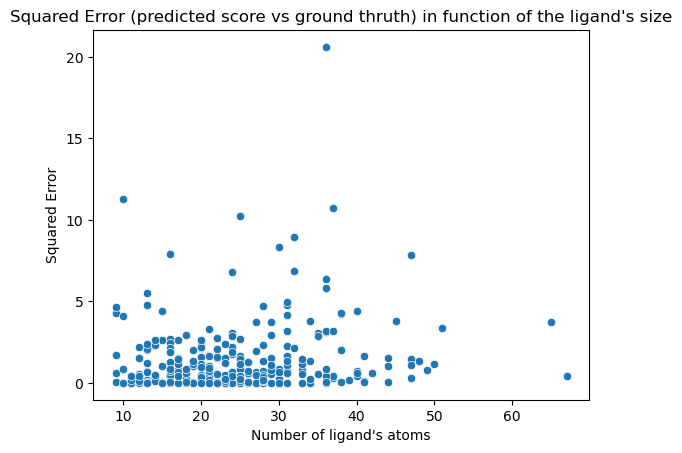

In [63]:
ax = sns.scatterplot(x = "nb_ligand_atoms", y = "MSE_Loss", data = df)
ax.set_title("Squared Error (predicted score vs ground thruth) in function of the ligand's size")
ax.set_xlabel("Number of ligand's atoms")
ax.set_ylabel("Squared Error")

Text(0, 0.5, 'Squared Error')

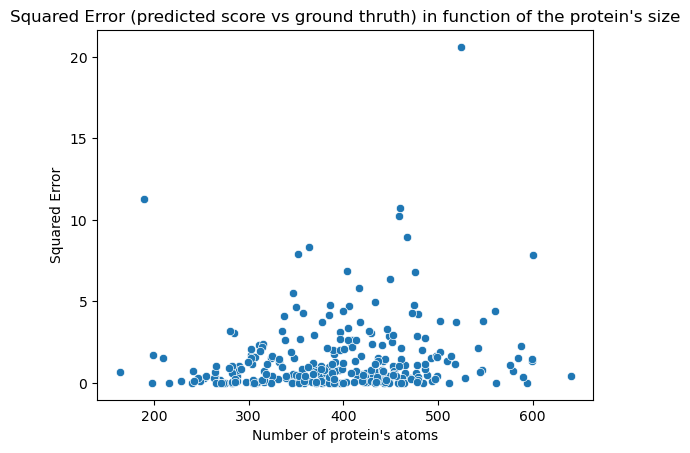

In [65]:
ax = sns.scatterplot(x = "nb_pocket_atoms", y = "MSE_Loss", data = df)
ax.set_title("Squared Error (predicted score vs ground thruth) in function of the protein's size")
ax.set_xlabel("Number of protein's atoms")
ax.set_ylabel("Squared Error")